# Exploratory Data Analysis (Part 2)

## Objective
This notebook explores the cleaned datasets generated in Part 1:
1. **`label_yield.parquet`**: Annual crop yield data.
2. **`nasa_df.parquet`**: Monthly weather data (Rain, Solar Radiation, Temperature).

We aim to understand the data distributions, trends over time, and the relationship between weather variables and crop yields, with a specific focus on **Cereals (Barley, Wheat, Rice, and Maize/Corn)**.

### 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the processed data
yield_df = pd.read_parquet('Parquet/label_yield.parquet')
nasa_df = pd.read_parquet('Parquet/nasa_df.parquet')
farming_df = pd.read_parquet('Parquet/farming_df.parquet')

print("Yield Data Shape:", yield_df.shape)
print("Weather Data Shape:", nasa_df.shape)
print("Farming Data Shape:", farming_df.shape)

Yield Data Shape: (89260, 4)
Weather Data Shape: (107844, 5)
Farming Data Shape: (14977, 4)


### 2. General Crop Yield Overview
Before narrowing down, we compare the scale of yields across different crops to understand the global landscape.

C:\Users\Trin Uthaisang\AppData\Local\Temp\ipykernel_31060\2136797903.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')


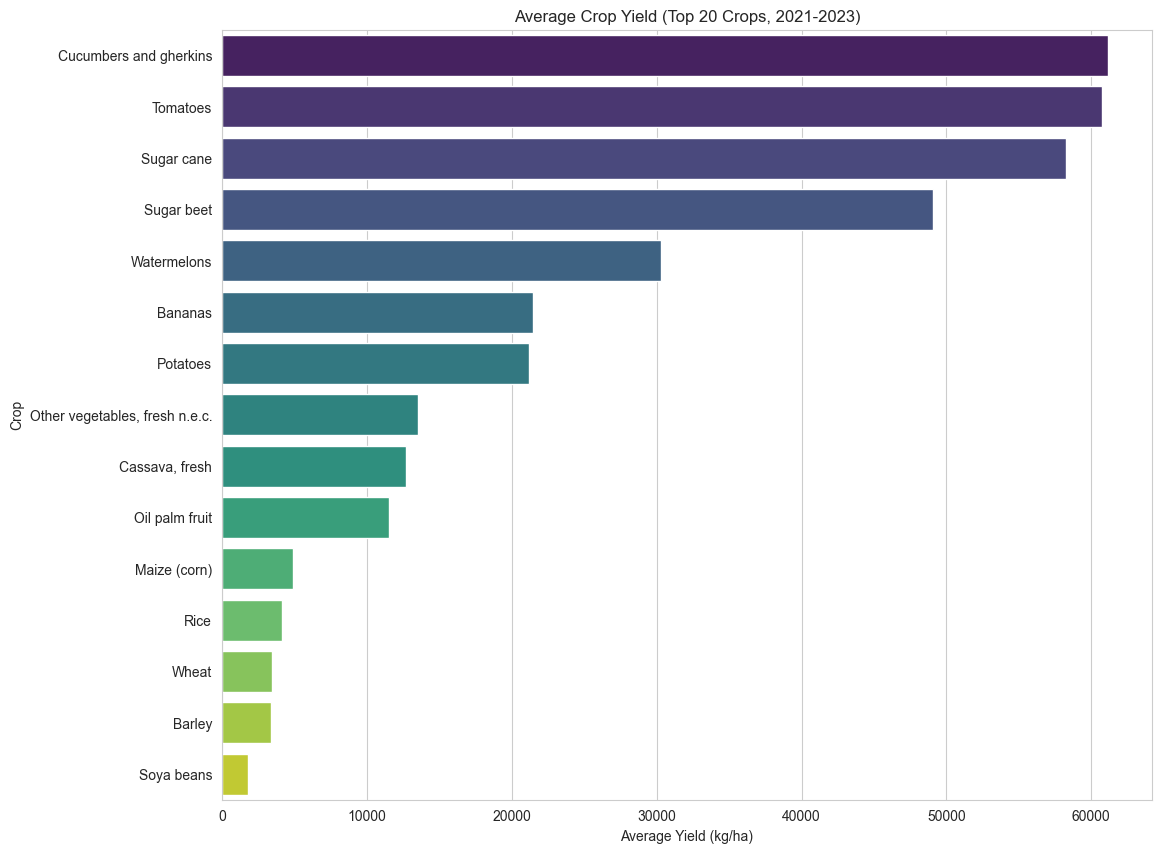

In [3]:
# 1. Identify the last 3 years in the dataset for a recent snapshot
max_year = pd.to_datetime(yield_df['year']).dt.year.max()
recent_years = [max_year, max_year-1, max_year-2]

# 2. Filter for recent data
recent_df = yield_df[pd.to_datetime(yield_df['year']).dt.year.isin(recent_years)]

# 3. Calculate average yield per crop
avg_yield_by_crop = recent_df.groupby('item')['label'].mean().reset_index()

# 4. Sort from highest to lowest (Top 20)
avg_yield_by_crop = avg_yield_by_crop.sort_values(by='label', ascending=False).head(20)

# 5. Plot
plt.figure(figsize=(12, 10))
sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')
plt.title(f'Average Crop Yield (Top 20 Crops, {min(recent_years)}-{max_year})')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.show()

### 3. Focus on Cereals
We will now filter the dataset to focus exclusively on the specified cereals: **Barley, Wheat, Rice, and Maize (Corn)**.

In [4]:
# Define the target cereals using regex for flexibility
# Matches 'Rice, paddy', 'Maize (corn)', etc.
target_pattern = r"Barley|Wheat|Rice|Maize|Corn"

# Filter data
cereals_df = yield_df[yield_df['item'].str.contains(target_pattern, case=False)].copy()

print("Cereals Data Shape:", cereals_df.shape)
print("Unique Crops found:", cereals_df['item'].unique())
print("Unique Areas producing Cereals:", cereals_df['area'].nunique())

cereals_df.head()

Cereals Data Shape: (25659, 4)
Unique Crops found: ['Maize (corn)' 'Rice' 'Wheat' 'Barley']
Unique Areas producing Cereals: 193


,area,item,year,label
0,Afghanistan,Maize (corn),1970-12-31,1475.7
1,Afghanistan,Maize (corn),1971-12-31,1340.0
2,Afghanistan,Maize (corn),1972-12-31,1565.2
3,Afghanistan,Maize (corn),1973-12-31,1617.0
4,Afghanistan,Maize (corn),1974-12-31,1617.0


#### 3.1 Cereal Yield Trends Over Time
We visualize how the yield of these key cereals has changed over the decades globally.

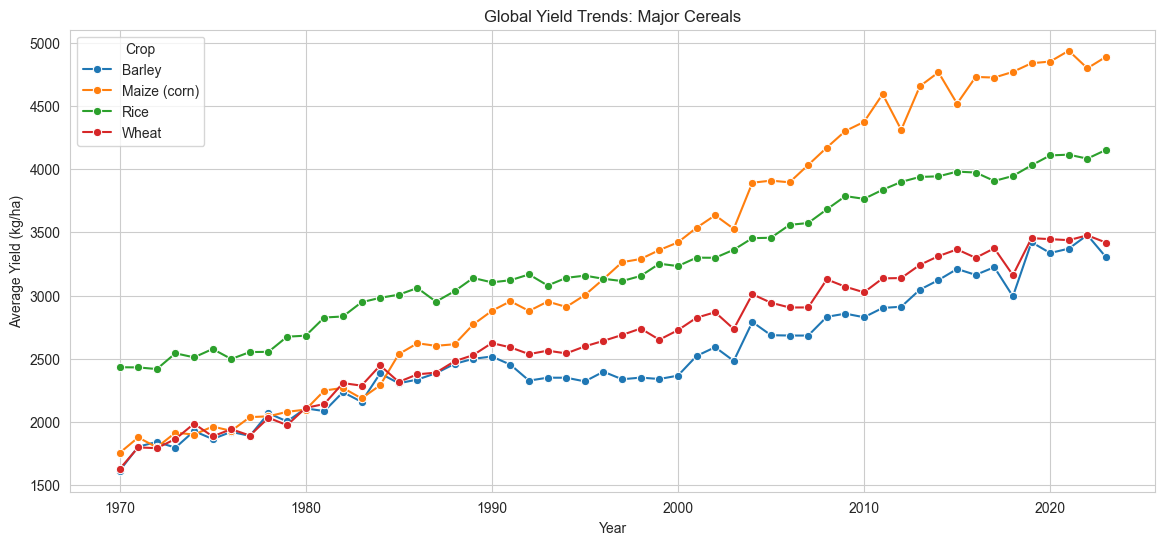

In [5]:
# Extract year number for plotting
cereals_df['year_num'] = pd.to_datetime(cereals_df['year']).dt.year

# Aggregate global average yield per crop per year
global_trends = cereals_df.groupby(['item', 'year_num'])['label'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(x='year_num', y='label', hue='item', data=global_trends, marker='o')
plt.title('Global Yield Trends: Major Cereals')
plt.xlabel('Year')
plt.ylabel('Average Yield (kg/ha)')
plt.legend(title='Crop')
plt.show()

### 4. Weather Data Distribution
We briefly inspect the spread of our weather data (Temperature, Rain, Solar Radiation).

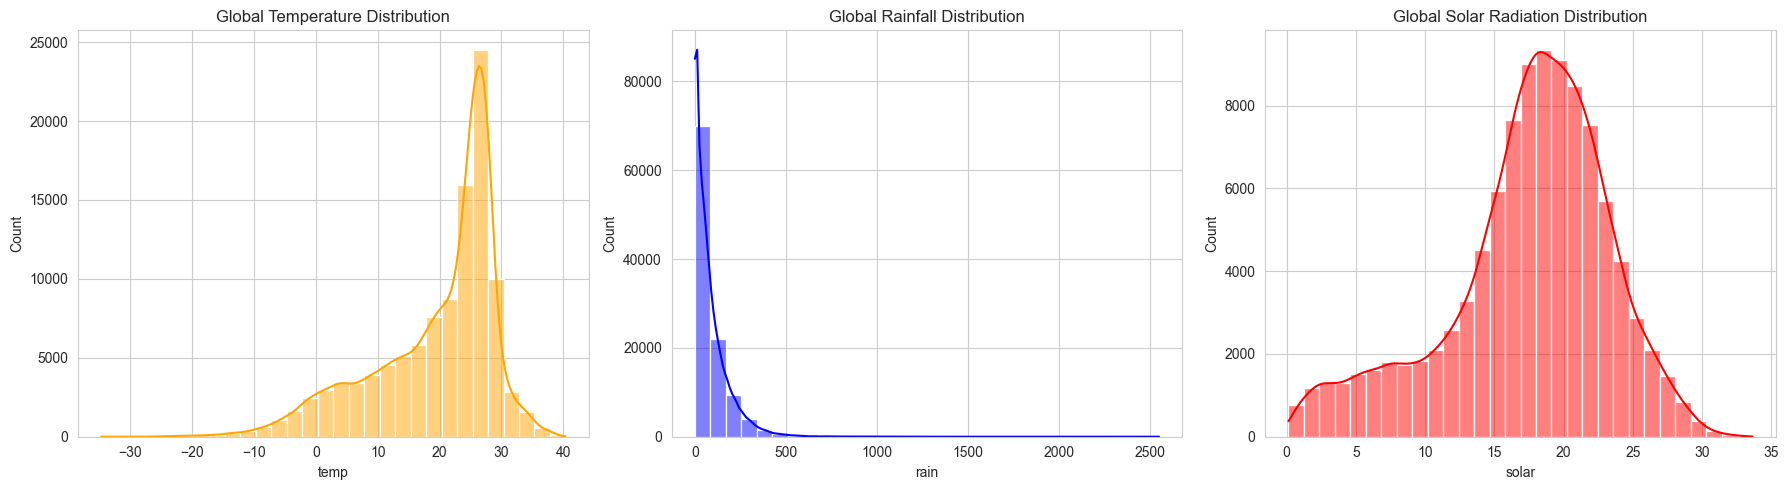

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(nasa_df['temp'].dropna(), bins=30, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Global Temperature Distribution')

sns.histplot(nasa_df['rain'].dropna(), bins=30, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Global Rainfall Distribution')

sns.histplot(nasa_df['solar'].dropna(), bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Global Solar Radiation Distribution')

plt.tight_layout()
plt.show()

### 5. Feature Engineering Tests
We check if past data (Lags and Moving Averages) are good predictors for future yields.

#### 5.1 Lag Analysis (Autocorrelation)
**Hypothesis:** Yield(t) is highly correlated with Yield(t-1).
*Crucial Note:* We groupby `['area', 'item']` to ensure we don't mix data between different crops or countries.

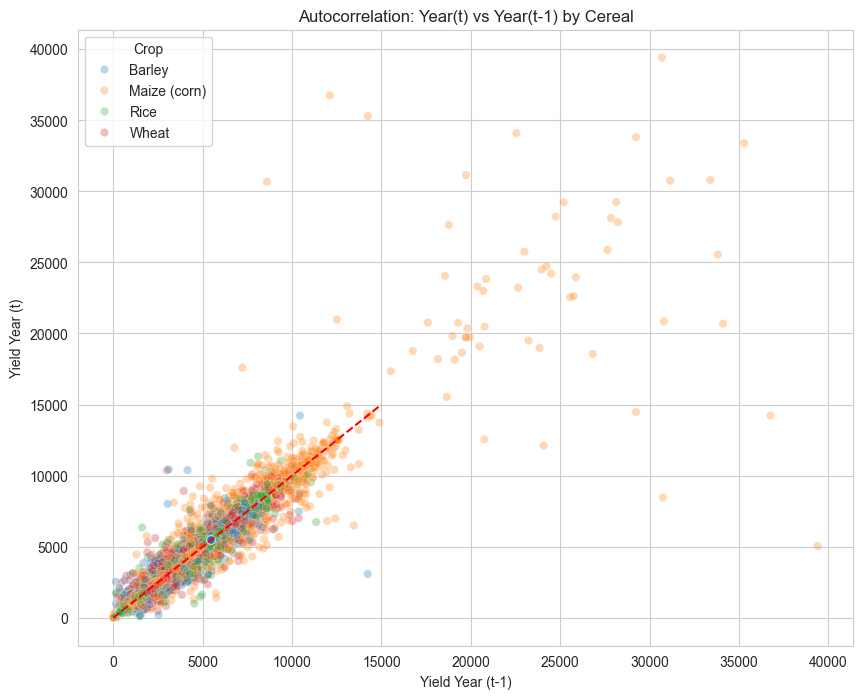

Overall Correlation between Year(t) and Year(t-1): 0.9542


In [7]:
# Create a temporary dataframe to calculate lags
lag_analysis = cereals_df.sort_values(['area', 'item', 'year_num']).copy()

# Calculate Previous Year Yield (Lag 1) grouped by Area AND Crop
lag_analysis['yield_lag_1'] = lag_analysis.groupby(['area', 'item'])['label'].shift(1)

# Filter for plot (Year >= 2010) for cleaner visualization
plot_data = lag_analysis[lag_analysis['year_num'] >= 2010]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='yield_lag_1', y='label', hue='item', data=plot_data, alpha=0.3)
plt.plot([0, 15000], [0, 15000], color='red', linestyle='--') # Reference line
plt.title('Autocorrelation: Year(t) vs Year(t-1) by Cereal')
plt.xlabel('Yield Year (t-1)')
plt.ylabel('Yield Year (t)')
plt.legend(title='Crop')
plt.show()

# Calculate overall correlation score
corr_score = lag_analysis['label'].corr(lag_analysis['yield_lag_1'])
print(f"Overall Correlation between Year(t) and Year(t-1): {corr_score:.4f}")

#### 5.2 Rolling Averages (Trend Analysis)
We check if a 3-year moving average (smoothing) predicts the trend well.

In [8]:
# 3-year lagged moving average (t-1, t-2, t-3)
lag_analysis['MA_3_lag'] = lag_analysis.groupby(['area', 'item'])['label'].shift(1).rolling(window=3).mean()

# Drop NA for metrics
valid = lag_analysis.dropna(subset=['MA_3_lag'])

# Compute R2
r2 = r2_score(valid['label'], valid['MA_3_lag'])
print(f"R² (Actual vs MA_3_lag): {r2:.4f}")

R² (Actual vs MA_3_lag): 0.9168


### 6. Correlation: Weather/Farming Data vs. Cereal Yields
1. Aggregate monthly weather to annual averages.
2. Merge with Cereals data.
3. Check correlation matrix.

Fertilizer columns detected: ['fertilizer']
Pesticide columns detected: ['pesticides']
Merged_full shape: (20913, 9)
Columns included in final correlation: ['label', 'rain', 'temp', 'solar', 'fertilizer', 'pesticides']


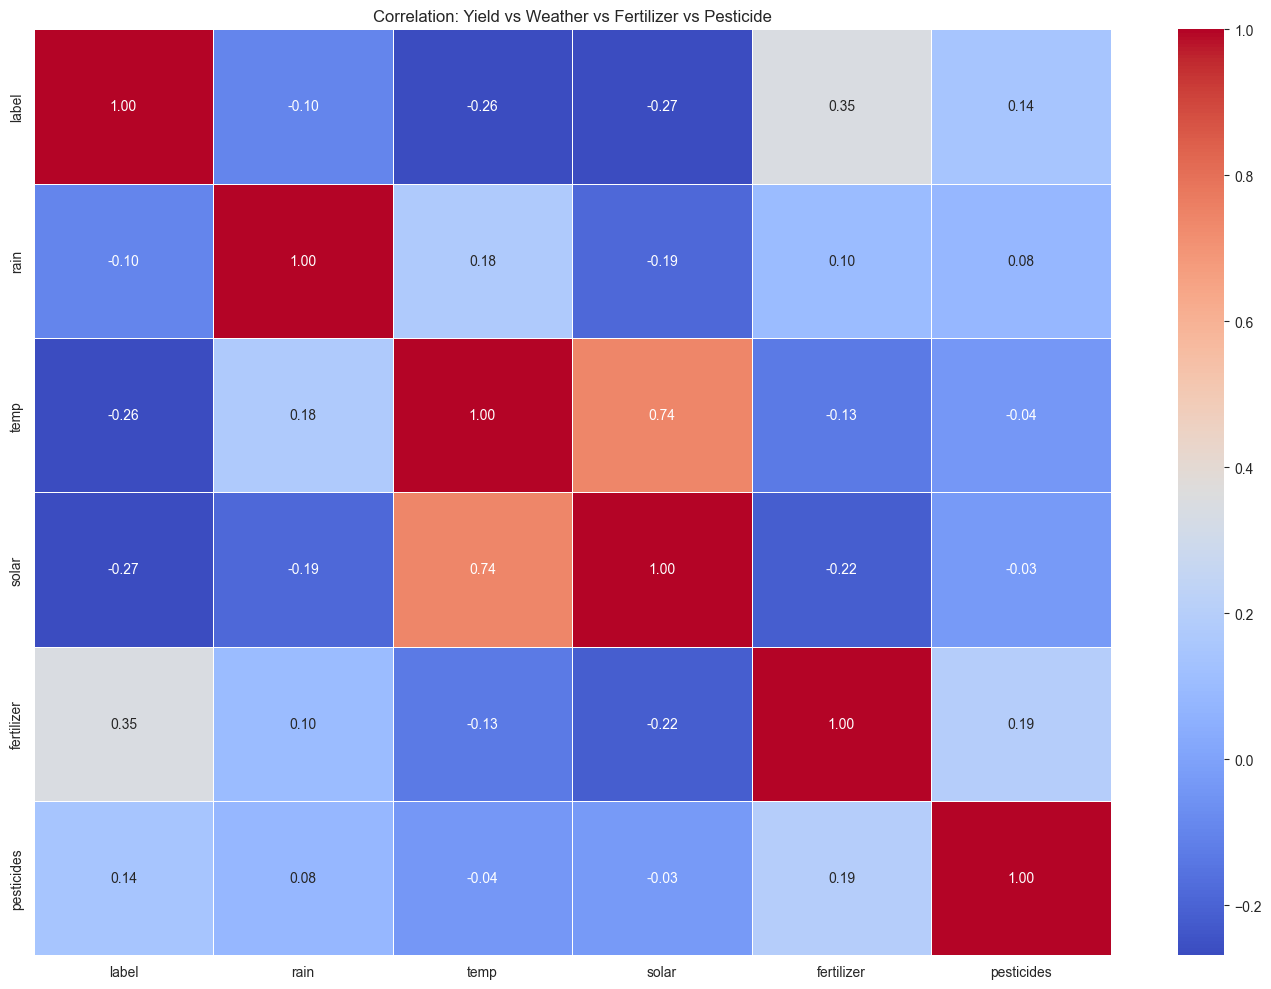

In [9]:
# ==============================================================
# 1. Ensure YEAR columns are in numeric (int) year format
# ==============================================================

nasa_df['year'] = pd.to_datetime(nasa_df['date']).dt.year
farming_df['year'] = pd.to_datetime(farming_df['year']).dt.year

# ==============================================================
# 2. Aggregate WEATHER by area & year
# ==============================================================
weather_annual = (
    nasa_df
    .groupby(['area', 'year'])
    .agg({
        'rain': 'sum',   # total rain per year
        'temp': 'mean',  # mean temperature per year
        'solar': 'mean', # mean solar per year
    })
    .reset_index()
)

# ==============================================================
# 3. Prepare CEREALS DATA (yield label per area-year)
# ==============================================================
# cereals_df is assumed to have: area, item, year_num, label
cereals_merge = (
    cereals_df[['area', 'item', 'year_num', 'label']]
    .rename(columns={'year_num': 'year'})
)

# Merge cereals with weather
merged_df = pd.merge(
    cereals_merge,
    weather_annual,
    on=['area', 'year'],
    how='inner'
)

# ==============================================================
# 4. Detect fertilizer & pesticide columns in farming_df
# ==============================================================
fert_cols = [
    c for c in farming_df.columns
    if any(key in c.lower() for key in ['fert', 'fertilizer'])
]

pest_cols = [
    c for c in farming_df.columns
    if any(key in c.lower() for key in ['pest', 'pesticides'])
]

fert_pest_cols = fert_cols + pest_cols

print("Fertilizer columns detected:", fert_cols)
print("Pesticide columns detected:", pest_cols)

# If nothing is detected, this will warn you so you can adjust patterns
if not fert_pest_cols:
    print("⚠ No fertilizer/pesticide columns detected. Check farming_df.columns:")
    print(list(farming_df.columns))

# ==============================================================
# 5. Build annual fertilizer/pesticide data (area-year level)
# ==============================================================
fert_pest_df = farming_df[['area', 'year'] + fert_pest_cols].copy()

# Make sure fert/pest columns are numeric
for col in fert_pest_cols:
    fert_pest_df[col] = pd.to_numeric(fert_pest_df[col], errors='coerce')

# Aggregate (in case there are multiple rows per area-year)
fert_pest_annual = (
    fert_pest_df
    .groupby(['area', 'year'])[fert_pest_cols]
    .mean()
    .reset_index()
)

# ==============================================================
# 6. Merge all: cereals + weather + fertilizer/pesticide
# ==============================================================
merged_full = pd.merge(
    merged_df,
    fert_pest_annual,
    on=['area', 'year'],
    how='left'
)

print("Merged_full shape:", merged_full.shape)

# ==============================================================
# 7. Build correlation DataFrame (only numeric columns)
# ==============================================================
# Base correlation features
corr_features = ['label', 'rain', 'temp', 'solar'] + fert_pest_cols

# Keep only features that actually exist
existing_features = [c for c in corr_features if c in merged_full.columns]

# Filter numeric-only (in case anything is still non-numeric)
corr_df = merged_full[existing_features].select_dtypes(include=[np.number])

print("Columns included in final correlation:", list(corr_df.columns))

# ==============================================================
# 8. Compute & plot ONE correlation heatmap
# ==============================================================
plt.figure(figsize=(14, 10))
corr_matrix = corr_df.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title('Correlation: Yield vs Weather vs Fertilizer vs Pesticide')
plt.tight_layout()
plt.show()

### 7. Seasonal Weather Trends
We analyze the average weather conditions by month to understand global seasonal patterns.

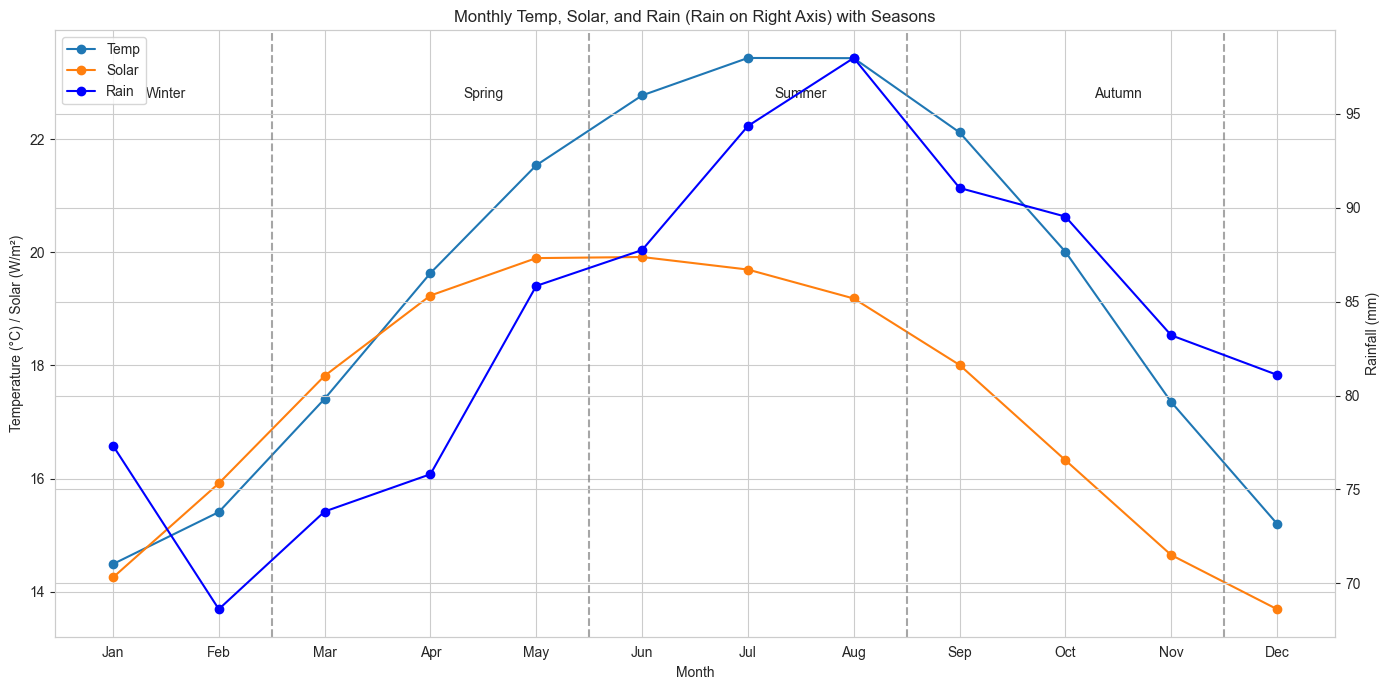

In [10]:
import matplotlib.pyplot as plt

# Create month column
nasa_df['month'] = pd.to_datetime(nasa_df['date']).dt.month

# Aggregate monthly averages
seasonal_weather = nasa_df.groupby('month')[['rain', 'temp', 'solar']].mean()

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: temp and solar
ln1 = ax1.plot(seasonal_weather.index, seasonal_weather['temp'], marker='o', label='Temp')
ln2 = ax1.plot(seasonal_weather.index, seasonal_weather['solar'], marker='o', label='Solar')
ax1.set_ylabel("Temperature (°C) / Solar (W/m²)")

# Right axis: rain
ax2 = ax1.twinx()
ln3 = ax2.plot(seasonal_weather.index, seasonal_weather['rain'], marker='o', label='Rain', color='blue')
ax2.set_ylabel("Rainfall (mm)")

# X-axis labels
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax1.set_xlabel("Month")

# Add vertical lines to separate seasons
season_boundaries = [2.5, 5.5, 8.5, 11.5]  # between winter/spring, spring/summer, summer/autumn, autumn/winter
for x in season_boundaries:
    ax1.axvline(x=x, color='gray', linestyle='--', alpha=0.7)

# Annotate seasons
ax1.text(1.5, ax1.get_ylim()[1]*0.95, 'Winter', ha='center')
ax1.text(4.5, ax1.get_ylim()[1]*0.95, 'Spring', ha='center')
ax1.text(7.5, ax1.get_ylim()[1]*0.95, 'Summer', ha='center')
ax1.text(10.5, ax1.get_ylim()[1]*0.95, 'Autumn', ha='center')

# Combine legends
lns = ln1 + ln2 + ln3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc="upper left")

plt.title("Monthly Temp, Solar, and Rain (Rain on Right Axis) with Seasons")
plt.tight_layout()
plt.show()


### 8. Geographic Analysis
**Why this matters for Part 5:** 
As yield varies heavily by location, we must include Country/Region as a categorical feature.

In [11]:
import pandas as pd
import plotly.express as px

# --- 1. Load Yield Data ---
# Ensure 'Data/yield_final.csv' exists in your directory
try:
    yield_df = pd.read_csv('Data/yield_final.csv')
    
    # Filter: Rice only, Last 3 Years
    rice_df = yield_df[yield_df['Item'].str.contains('Rice', case=False, na=False)].copy()
    max_year = rice_df['Year'].max()
    recent_rice_df = rice_df[rice_df['Year'] >= (max_year - 2)].copy()

    # Aggregate: Average Yield per Country
    country_stats = recent_rice_df.groupby('Area')['Yield (kg/ha)'].mean().reset_index()
    print(f"Yield Data: {len(country_stats)} countries prepared.")
except FileNotFoundError:
    print("Error: 'Data/yield_final.csv' not found. Please check the file path.")
    country_stats = pd.DataFrame() # Empty fallback

# --- 2. Skip Coordinates (Not Needed for Plotly Choropleth) ---

# --- 3. Plotting with Plotly (Alternative to GeoPandas/Matplotlib) ---
if not country_stats.empty:
    # Rename 'Area' to 'Country' for clarity (optional)
    country_stats = country_stats.rename(columns={'Area': 'Country'})

    # Create Choropleth Map
    fig = px.choropleth(
        country_stats,
        locations='Country',
        color='Yield (kg/ha)',
        locationmode='country names',  # Matches country names automatically
        color_continuous_scale='YlGn',  # Similar to Matplotlib's cmap
        title=f'Global Rice Yield (Choropleth) - {max_year-2}-{max_year}',
        labels={'Yield (kg/ha)': 'Average Rice Yield (kg/ha)'},
        hover_name='Country',
        hover_data={'Yield (kg/ha)': True},
        projection='natural earth'  # Nice world map projection
    )

    # Update Layout for Better Visualization
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(
            title='Average Rice Yield (kg/ha)',
            orientation='h',
            len=0.5,
            yanchor='bottom',
            y=-0.1
        ),
        geo=dict(
            showframe=False,
            showcoastlines=True,
            coastlinecolor='white',
            landcolor='#f0f0f0',
            showland=True,
            showcountries=True,
            countrycolor='black',
            countrywidth=0.5
        )
    )

    fig.show()

else:
    print("Skipping plot: Missing data files.")

Yield Data: 118 countries prepared.


C:\Users\Trin Uthaisang\AppData\Local\Temp\ipykernel_31060\2645638256.py:29: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(
